# Competition description
> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
> 
> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
> 
> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

# Objectives
This is my first Kaggle competition and the first project that I will do by myself. I've completed the Andrew Ng course on ML and watched a bunch of videos about numpy, pandas and sci-kit learn. My objectives with this notebook is to keep learning putting into practice what I already "know" as well as what I will learn during participating in this competition. This notebook is highly inspired in other kernels that I saw as well. I hope I can learn writing this kernel.

# Index
1. Data Cleaning  
    1.1 Missing Values  
    1.2 Dummy Variables  
    1.3 Cabin Letters  
2. Feature Engineering  
    2.1 Family Names   
    2.2 Title  
    2.3 Family Size  
    2.4 Fare and Age Bins  
3. Visualization  
    3.1 Correlation Matrix  
    3.2 Age, Fare, Sex Analysis  
    3.3 Who survived per groups  
4. Choosing a Model (Logistic Regression)  
5. Predicting  
6. What else can be done?  
    6.1 Better Feature Selection (RFE)  
    6.2 Age Linear Regression    
    
   

# Setting Environment

In [3]:
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Model Selection and Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14,10
sns.set()
sns.set_color_codes()

In [4]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

# Copy for the preprocessing
df1_train = df_train.copy()
df1_test = df_test.copy()
df_total = pd.concat([df_train, df_test])

data_cleaner = [df_train, df_test] # Easy application of cleaning

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Preprocessing

We know that the features are:
* Survived: 旅客是否幸存
* PassengerId:  旅客编号
* Pclass: 旅客等级
* Name: 姓名
* Sex: 性别
* SibSp: 携带兄妹人数
* Parch: 携带配偶,小孩人数
* Ticket: can have some hidden importance (maybe correlated with fare or pclass) but I will assume it has random data that can be discarded at first
* Fare, Age: 票价,年龄
* Cabin: 客舱编号
* Embarked: 登船港口

We can discard Ticket and PassengerId since these are assumed to be random caracters.

In [6]:
for df in data_cleaner:
    df.drop(["PassengerId", "Ticket"], axis=1, inplace=True)

In [7]:
df_train.info()
print('*'*10)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB


## 1.1 Missing Values

We can see from the data loaded that there is missing values in Age, Fare, Embarked and (more critically) in Cabin features. For Fare and Age it is reasonable to pick the mean or the median (last will be used as it handles outliers better), for Embarked mode will be used. We couldn't use something similar with Cabin as it has so many missing data, so it will be assigned a letter M for missing in the examples without Cabin data.

In [8]:
# Simple imputation
for df in data_cleaner:
    df["Age"].fillna(df_train.Age.median(), inplace=True)
    df["Fare"].fillna(df_train.Fare.median(), inplace=True)
    df["Embarked"].fillna(df_train.Embarked.mode()[0], inplace=True)
    df["Cabin"].fillna('M', inplace=True)

In [9]:
# Check if there are still any missing value
print(df_train.isnull().any())
print('*'*10)
print(df_test.isnull().any())

Survived    False
Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Cabin       False
Embarked    False
dtype: bool
**********
Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Cabin       False
Embarked    False
dtype: bool


# 1.2 Feature Engineering

We can extract title and family names from the Name feature

In [10]:
def extract_name(f):
    return f.split(', ')[0]

def extract_title(f):
    return (f.split(", ")[1]).split(".")[0]

In [11]:
for df in data_cleaner:
    df["FamilyName"] = df.Name.apply(extract_name)
    df["Title"] = df.Name.apply(extract_title)

### 1.2.1 Family Name

In [12]:
df_train.FamilyName.value_counts().head(10)

Andersson     9
Sage          7
Carter        6
Goodwin       6
Skoog         6
Panula        6
Johnson       6
Rice          5
Lefebre       4
Gustafsson    4
Name: FamilyName, dtype: int64

We can pick categories for names with more than 5 individuals:

In [13]:
family_names = df_train.FamilyName

for df in data_cleaner:
    df["FamilyName"] = df.FamilyName.apply(lambda f: f if f in family_names.unique() and
                                     family_names.value_counts()[f] > 5 else 'Other')

In [14]:
df_train['FamilyName'].value_counts()

Other        845
Andersson      9
Sage           7
Carter         6
Skoog          6
Johnson        6
Panula         6
Goodwin        6
Name: FamilyName, dtype: int64

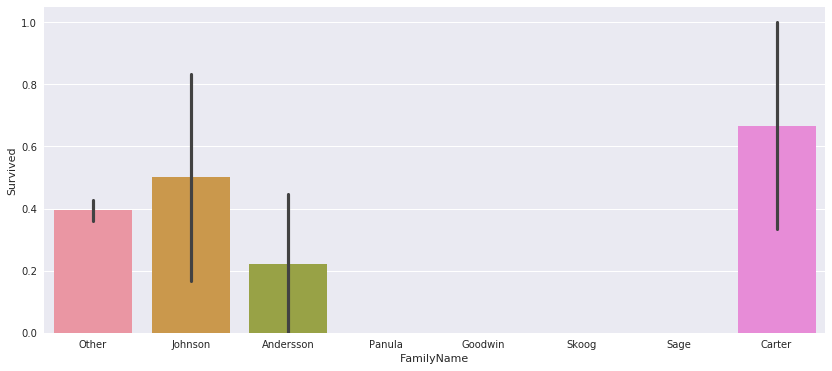

In [15]:
plt.figure(figsize=(14,6))
sns.barplot("FamilyName", "Survived", data=df_train)
plt.show()

In [16]:
# For now I think these numbers has little to contribute
for df in data_cleaner:
    df.drop(["FamilyName"], axis=1, inplace=True)

### 1.2.2 Title

In [17]:
titles = df_train.Title

In [18]:
titles.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

We first can group some of the classes togheter and then realize the same analysis as the above.

In [19]:
miss = ["Ms", "Mlle"]
mrs = ["Mme"]

for df in data_cleaner:
    df["Title"] = df.Title.apply(lambda f: 'Miss' if f in miss else f)
    df["Title"] = df.Title.apply(lambda f: 'Mrs' if f in mrs else f)

In [20]:
titles = df_train.Title

for df in data_cleaner:
    df["Title"] = df.Title.apply(lambda f: f if f in titles.unique() and
                                     titles.value_counts()[f] > 10 else 'Rare')

In [21]:
df_train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

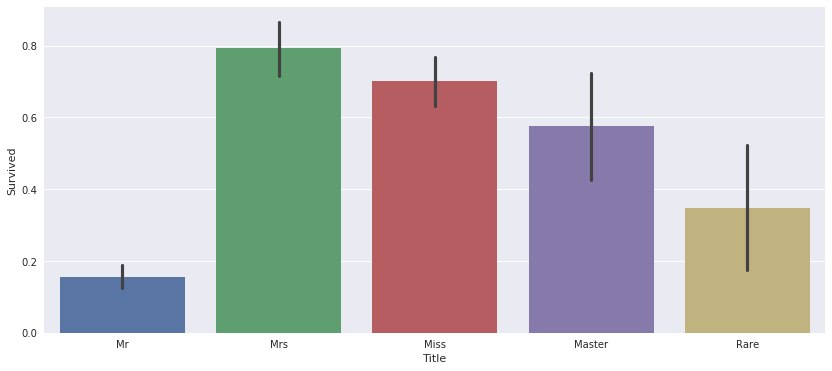

In [22]:
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=df_train)
plt.show()

From Mr, Mrs and Miss we see some intersection with the Sex feature. Master seems to indicate correlation with age, so we can create a variable holding if individual is a child

### 1.2.3 Child

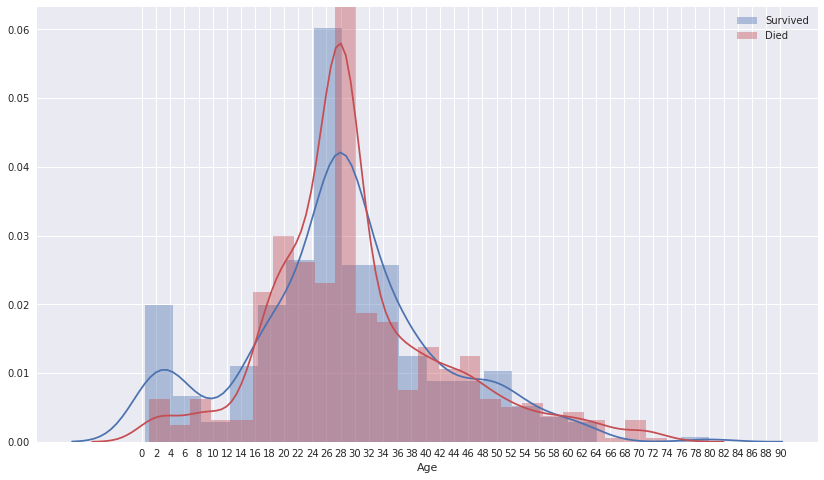

In [23]:
plt.figure(figsize=(14,8))
sns.distplot(df_train['Age'][df_train.Survived == 1], color='b')
sns.distplot(df_train['Age'][df_train.Survived == 0], color='r')
plt.xticks(range(0,92,2))
plt.legend(['Survived', 'Died'])
plt.show()

From the plot 16 seems to be a good point for determining as a child

In [24]:
for df in data_cleaner:
    df['IsChild'] = df['Age'] < 16

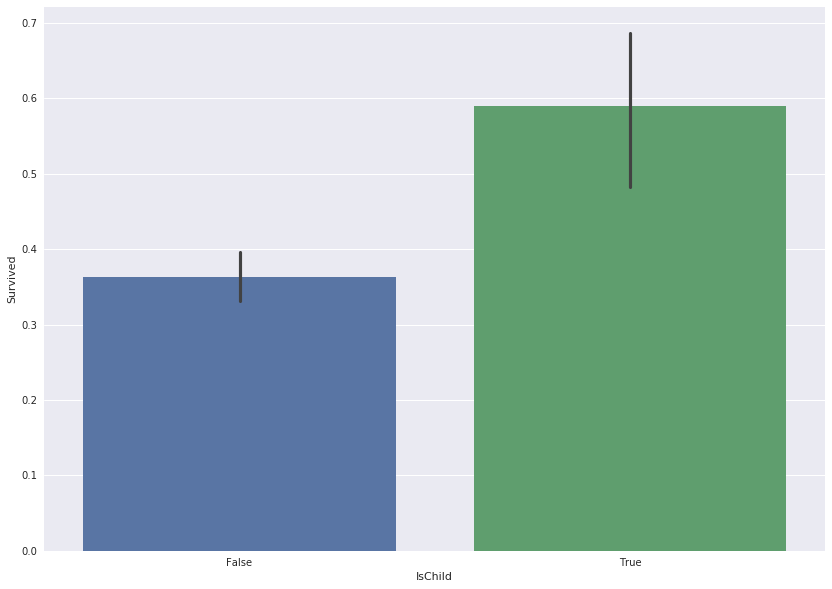

In [25]:
sns.barplot('IsChild', 'Survived', data=df_train)
plt.show()

### 1.2.3 Family Size

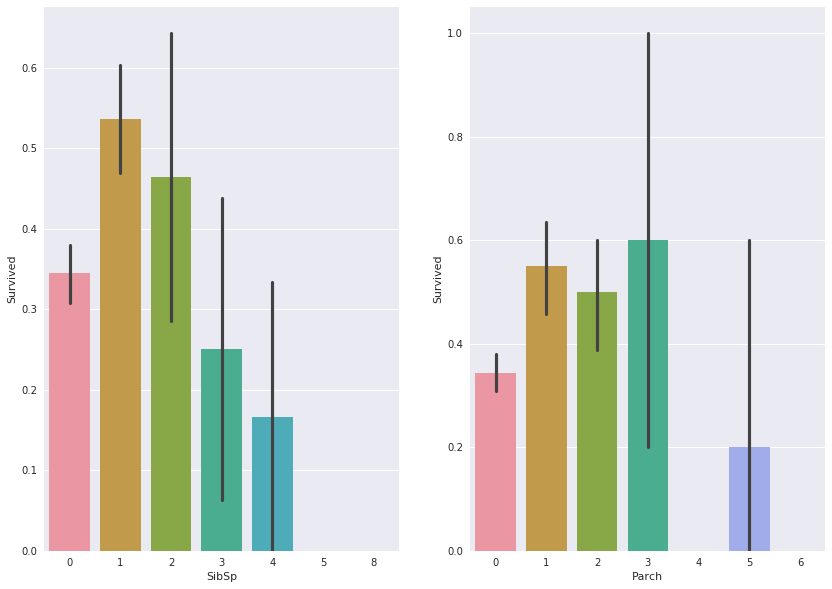

In [26]:
plt.subplot(121)
sns.barplot('SibSp', 'Survived', data=df_train)
plt.subplot(122)
sns.barplot('Parch', 'Survived', data=df_train)
plt.show()

We can easily create a new feature called family size for Parch + SibSp + Himself/Herself

In [27]:
for df in data_cleaner:
    df["FamilySize"] = df.Parch + df.SibSp +1

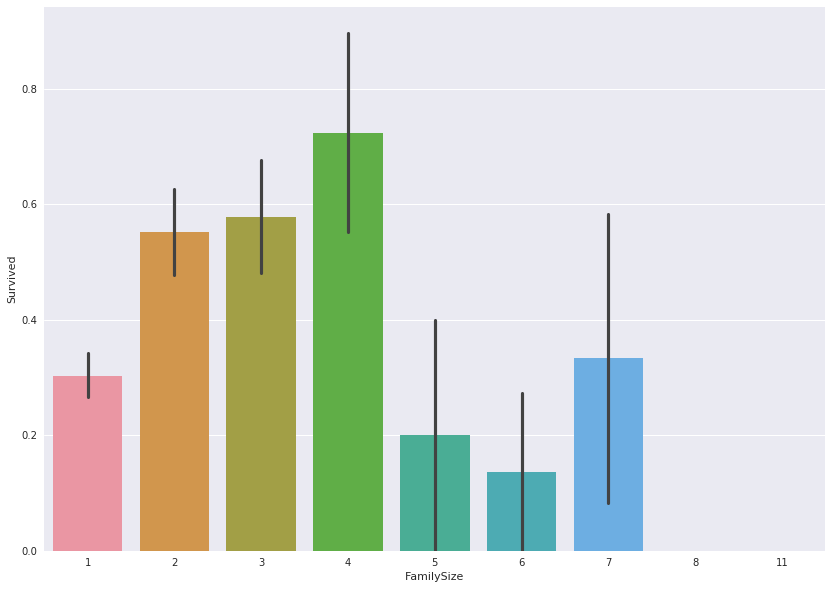

In [28]:
sns.barplot('FamilySize', 'Survived', data=df_train)
plt.show()

We can also define binary variables for alone individuals and individuals with a large family

In [29]:
for df in data_cleaner:
    df["IsAlone"] = df["FamilySize"] == 1
    df["LargeFamily"] = df["FamilySize"] >= 5

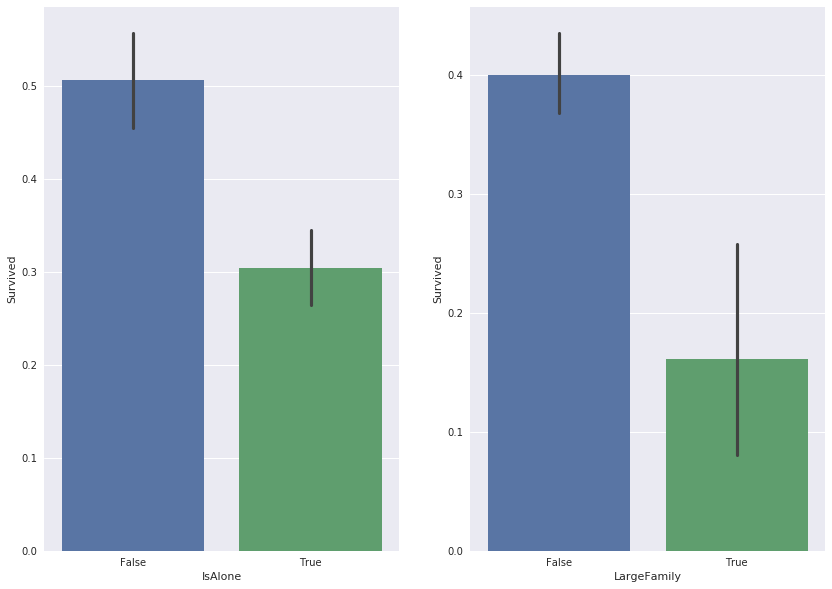

In [30]:
plt.subplot(121)
sns.barplot('IsAlone', 'Survived', data=df_train)
plt.subplot(122)
sns.barplot('LargeFamily', 'Survived', data=df_train)
plt.show()

### 1.2.4 Fare and Age bins

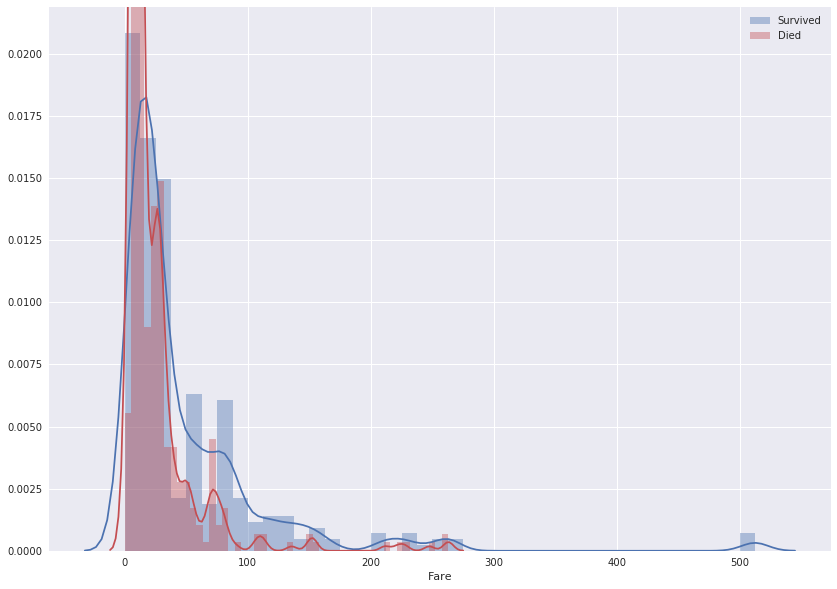

In [31]:
sns.distplot(df_train['Fare'][df_train.Survived == 1], color='b')
sns.distplot(df_train['Fare'][df_train.Survived == 0], color='r')
plt.legend(['Survived', 'Died'])
plt.show()

Another way of seeing the fare and age variables is by diividing into classes. I will Fare in 4 portions of equal individuals and Age in 5 portions of equal range

In [32]:
_, fare_bins = pd.qcut(df_total['Fare'], 4, retbins=True)
fare_bins[0] -= 0.001 # dirty fix
_, age_bins = pd.cut(df_total['Age'], 5, retbins=True)
for df in data_cleaner:
    df["FareBin"] = pd.cut(df['Fare'], fare_bins)
    df["AgeBin"] = pd.cut(df['Age'], age_bins)

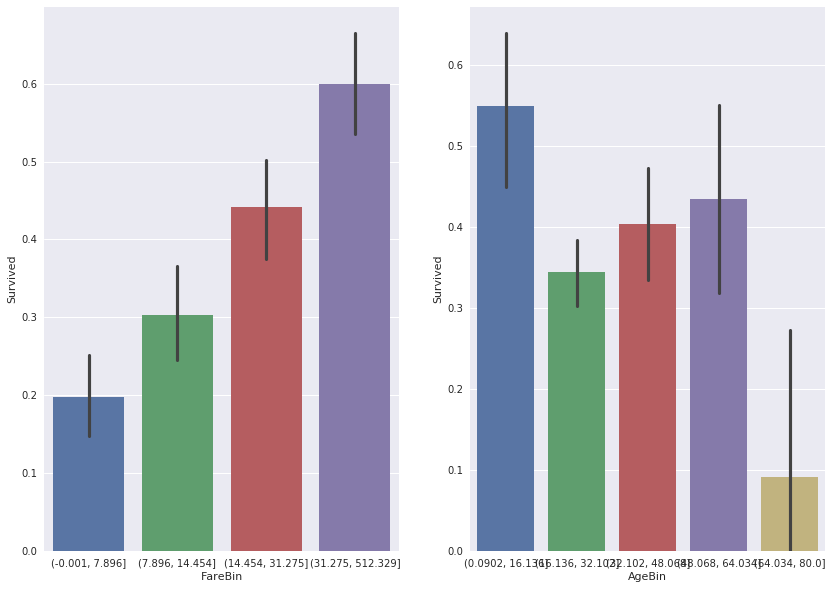

In [33]:
plt.subplot(121)
sns.barplot('FareBin', 'Survived', data=df_train)
plt.subplot(122)
sns.barplot('AgeBin', 'Survived', data=df_train)
plt.show()

AgeBins dont seem to be very imortant to the analysis, but child and old yes. I will create another category for the elder

In [34]:
for df in data_cleaner:
    df['IsOld'] = df['Age'] > 63

In [35]:
df_train.columns

Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Fare', u'Cabin', u'Embarked', u'Title', u'IsChild', u'FamilySize',
       u'IsAlone', u'LargeFamily', u'FareBin', u'AgeBin', u'IsOld'],
      dtype='object')

## 1.3 Cleaning

In [36]:
# Double check missing values
for df in data_cleaner:
    print(df.isnull().any())

Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
Title          False
IsChild        False
FamilySize     False
IsAlone        False
LargeFamily    False
FareBin        False
AgeBin         False
IsOld          False
dtype: bool
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
Title          False
IsChild        False
FamilySize     False
IsAlone        False
LargeFamily    False
FareBin        False
AgeBin         False
IsOld          False
dtype: bool


I will limit my analysis to the letter of the Cabin.

In [37]:
for df in data_cleaner:
    df["Cabin"] = df["Cabin"].apply(lambda f: f[0])

## 1.4 Converting the Formats

Create code variables for the categorical data

In [38]:
# Encode categorical data
label = LabelEncoder()
for df in data_cleaner:    
    df['Sex_Code'] = label.fit_transform(df['Sex'])
    df['Embarked_Code'] = label.fit_transform(df['Embarked'])
    df['Title_Code'] = label.fit_transform(df['Title'])
    df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])
    df['FareBin_Code'] = label.fit_transform(df['FareBin'])
    df['Cabin_Code'] = label.fit_transform(df["Cabin"])
     # Pclass can be viewed as categorical or simply an integer variable, which is best?
    df['Pclass'] = df.Pclass.astype('category')

In [39]:
df_train.columns

Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Fare', u'Cabin', u'Embarked', u'Title', u'IsChild', u'FamilySize',
       u'IsAlone', u'LargeFamily', u'FareBin', u'AgeBin', u'IsOld',
       u'Sex_Code', u'Embarked_Code', u'Title_Code', u'AgeBin_Code',
       u'FareBin_Code', u'Cabin_Code'],
      dtype='object')

In [40]:
# define masks

# target variable
target = ['Survived']

# pretty categorical names
data_pretty = ['Age', 'Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked',
                'FamilySize', 'FareBin', 'AgeBin', 'IsAlone', 'IsOld', 'IsChild', 'LargeFamily']

# continuous and integer variables
data_numbers = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']

# age and fare bins
data_bins = ['AgeBin_Code', 'FareBin_Code']

# categorical variables
data_cat = ['Pclass', 'Title', 'Sex', 'Cabin', 'Embarked' 'IsAlone',
            'IsOld', 'IsChild', 'LargeFamily']

# encoded categorical variables
data_code = ['Pclass', 'Title_Code', 'Sex_Code', 'Cabin_Code', 'Embarked_Code',
             'IsAlone', 'IsOld', 'IsChild', 'LargeFamily']

Create a dummy df of the categorical data

In [41]:
dummy_train = pd.get_dummies(df_train[data_pretty + target])
dummy_test = pd.get_dummies(df_test[data_pretty])

# mask for dummy variables
dummy_labels = dummy_test.columns.tolist()

In [42]:
dummy_train.head()

,Age,SibSp,Parch,Fare,FamilySize,IsAlone,IsOld,IsChild,LargeFamily,Survived,...,Embarked_S,"FareBin_(-0.001, 7.896]","FareBin_(7.896, 14.454]","FareBin_(14.454, 31.275]","FareBin_(31.275, 512.329]","AgeBin_(0.0902, 16.136]","AgeBin_(16.136, 32.102]","AgeBin_(32.102, 48.068]","AgeBin_(48.068, 64.034]","AgeBin_(64.034, 80.0]"
0,22.0,1,0,7.2500,2,False,False,False,False,0,...,1,1,0,0,0,0,1,0,0,0
1,38.0,1,0,71.2833,2,False,False,False,False,1,...,0,0,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,True,False,False,False,1,...,1,0,1,0,0,0,1,0,0,0
3,35.0,1,0,53.1000,2,False,False,False,False,1,...,1,0,0,0,1,0,0,1,0,0
4,35.0,0,0,8.0500,1,True,False,False,False,0,...,1,0,1,0,0,0,0,1,0,0


In [43]:
df_train[data_numbers].describe()

,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,0.523008,0.381594,32.204208,1.904602
std,13.019697,1.102743,0.806057,49.693429,1.613459
min,0.420000,0.000000,0.000000,0.000000,1.000000
25%,22.000000,0.000000,0.000000,7.910400,1.000000
50%,28.000000,0.000000,0.000000,14.454200,1.000000
75%,35.000000,1.000000,0.000000,31.000000,2.000000
max,80.000000,8.000000,6.000000,512.329200,11.000000


# 3. Visualization

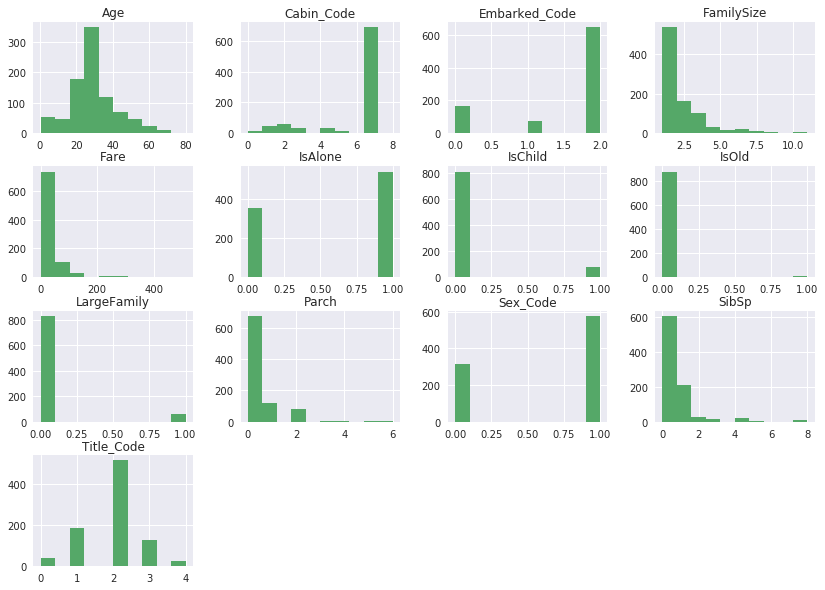

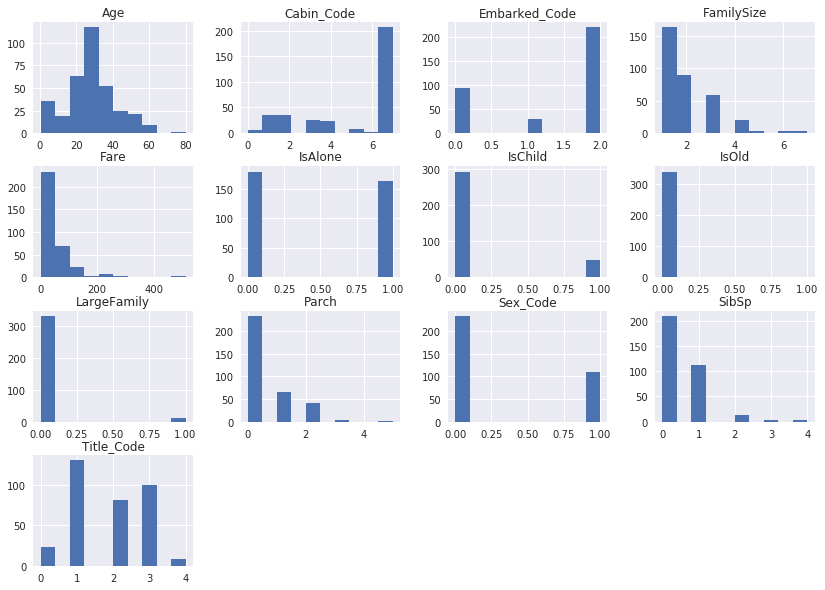

In [44]:
# Histogram of each feature count and survival count
df_train[data_numbers + data_code].hist(color='g')
df_train[data_numbers + data_code][df_train["Survived"] == 1].hist()
plt.show()

In [45]:
# Who survived per group
for x in data_pretty:
    if df_train[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(df_train[[x, target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

('Survival Correlation by:', 'Pclass')
  Pclass  Survived
0      1  0.629630
1      2  0.472826
2      3  0.242363
('----------', '\n')
('Survival Correlation by:', 'Title')
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826
('----------', '\n')
('Survival Correlation by:', 'Sex')
      Sex  Survived
0  female  0.742038
1    male  0.188908
('----------', '\n')
('Survival Correlation by:', 'SibSp')
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
('----------', '\n')
('Survival Correlation by:', 'Parch')
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
('----------', '\n')
('Survival Correlation by:', 'Cabin')
  Cabin  Survived
0     A  0.466667
1     B  0.744681
2     C  0.593220
3     D  0.757576
4     E  0.750000


In [46]:
# Correlation Matrix
df_train.corr()

,Survived,Age,SibSp,Parch,Fare,IsChild,FamilySize,IsAlone,LargeFamily,IsOld,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code,Cabin_Code
Survived,1.000000,-0.064910,-0.035322,0.081629,0.257307,0.136107,0.016639,-0.203367,-0.125147,-0.076793,-0.543351,-0.167675,-0.071174,-0.043800,0.306855,-0.295113
Age,-0.064910,1.000000,-0.233296,-0.172482,0.096688,-0.566310,-0.245619,0.171647,-0.204206,0.369588,0.081163,-0.018754,0.476260,0.939139,0.092395,-0.255553
SibSp,-0.035322,-0.233296,1.000000,0.414838,0.159651,0.352437,0.890712,-0.584471,0.730691,-0.040758,-0.114631,0.068230,-0.209813,-0.218747,0.378720,0.041058
Parch,0.081629,-0.172482,0.414838,1.000000,0.216225,0.351481,0.783111,-0.583398,0.631523,0.012075,-0.245489,0.039798,-0.117587,-0.135227,0.374659,-0.031553
Fare,0.257307,0.096688,0.159651,0.216225,1.000000,0.003753,0.217138,-0.271832,0.143636,0.035489,-0.182333,-0.224719,-0.013273,0.123640,0.583181,-0.525742
IsChild,0.136107,-0.566310,0.352437,0.351481,0.003753,1.000000,0.416472,-0.347400,0.337280,-0.038999,-0.111141,-0.012338,-0.501473,-0.509342,0.157825,0.073947
FamilySize,0.016639,-0.245619,0.890712,0.783111,0.217138,0.416472,1.000000,-0.690922,0.814901,-0.021824,-0.200988,0.066516,-0.202145,-0.217063,0.446015,0.012298
IsAlone,-0.203367,0.171647,-0.584471,-0.583398,-0.271832,-0.347400,-0.690922,1.000000,-0.336825,0.041412,0.303646,0.063532,0.017610,0.123981,-0.555148,0.137901
LargeFamily,-0.125147,-0.204206,0.730691,0.631523,0.143636,0.337280,0.814901,-0.336825,1.000000,0.003509,-0.102954,0.110061,-0.238051,-0.195639,0.252877,0.071347
IsOld,-0.076793,0.369588,-0.040758,0.012075,0.035489,-0.038999,-0.021824,0.041412,0.003509,1.000000,0.089764,-0.023359,0.039873,0.382870,0.030671,-0.092183


In [47]:
# Correlation Heatmap

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    colormap = sns.color_palette("coolwarm", 100)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_train)

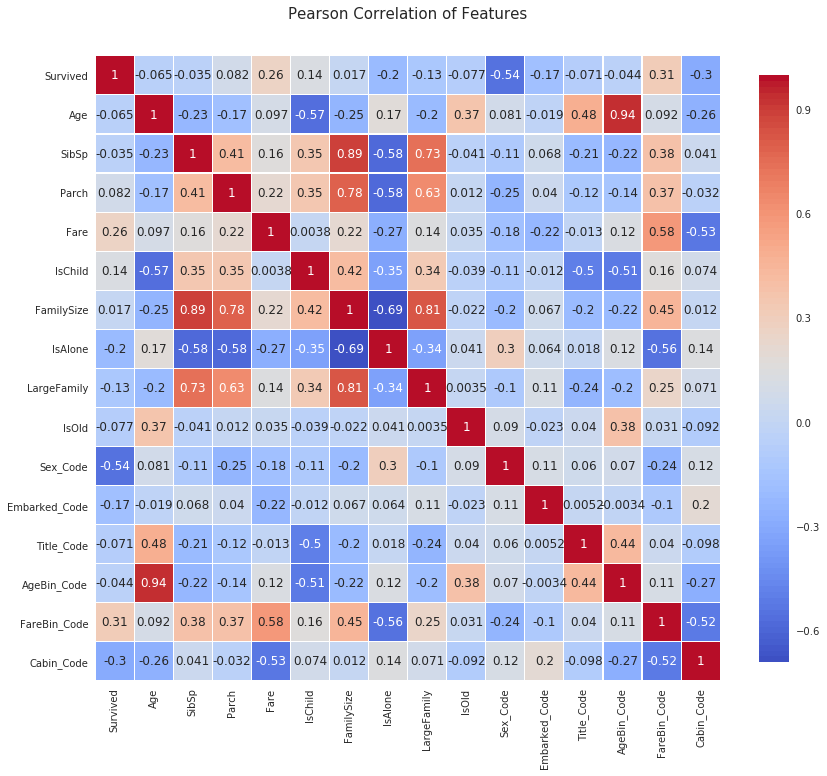

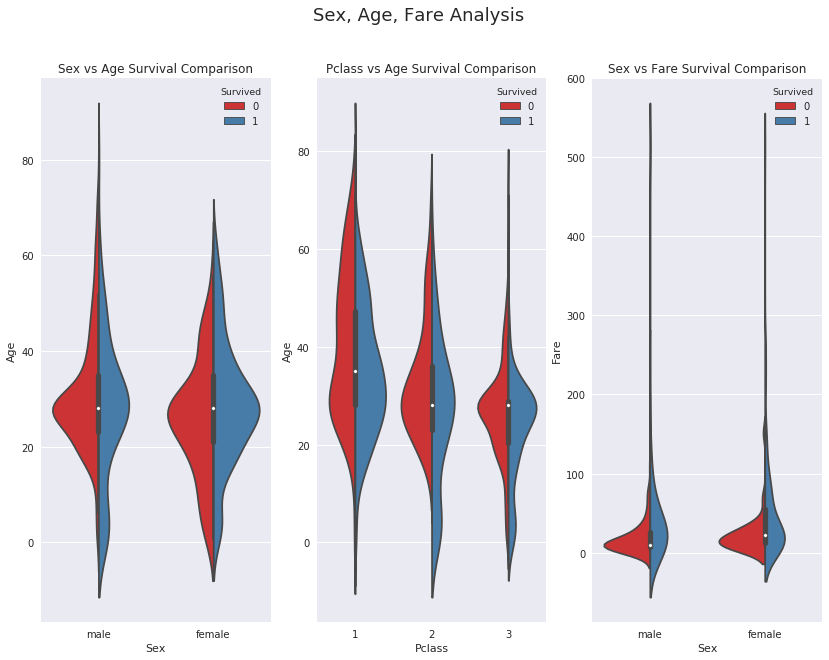

In [48]:
# Violin plots for sex-age-fare analysis

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,10))
sns.violinplot(x = 'Sex', y = 'Age', hue = 'Survived', data = df_train, split = True, ax = axis1, palette="Set1")
axis1.set_title('Sex vs Age Survival Comparison')
sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = df_train, split = True, ax = axis2, palette="Set1")
axis2.set_title('Pclass vs Age Survival Comparison')
sns.violinplot(x = 'Sex', y = 'Fare', hue = 'Survived', data = df_train, split = True, ax = axis3, palette="Set1")
axis3.set_title('Sex vs Fare Survival Comparison')
fig.suptitle("Sex, Age, Fare Analysis", fontsize=18)
plt.show()

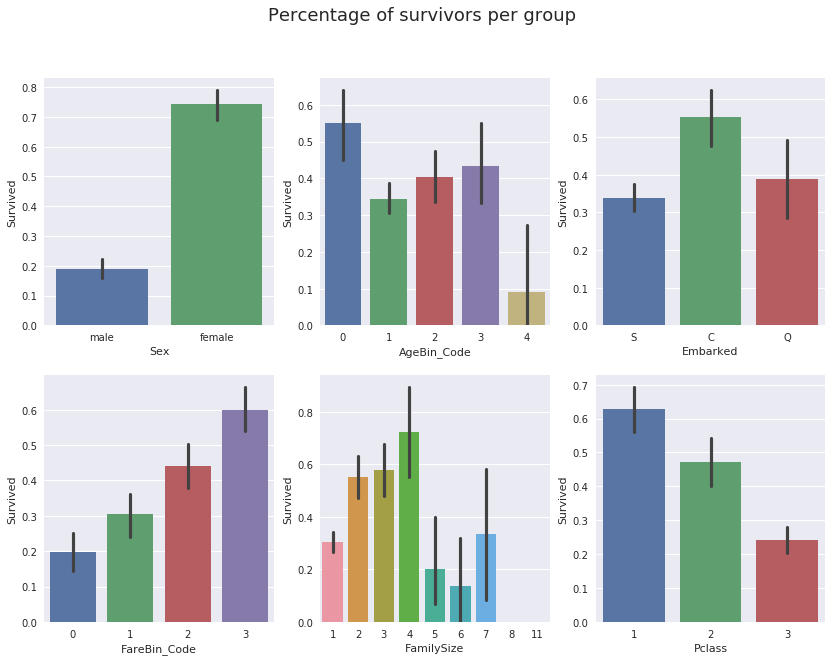

In [49]:
plt.figure(figsize=(14,10))
plt.suptitle("Percentage of survivors per group", fontsize=18)
plt.subplot(231)
sns.barplot('Sex', 'Survived', data=df_train)
plt.subplot(232)
sns.barplot('AgeBin_Code', 'Survived', data=df_train)
plt.subplot(233)
sns.barplot('Embarked', 'Survived', data=df_train)
plt.subplot(234)
sns.barplot('FareBin_Code', 'Survived', data=df_train)
plt.subplot(235)
sns.barplot('FamilySize', 'Survived', data=df_train)
plt.subplot(236)
sns.barplot('Pclass', 'Survived', data=df_train)
plt.show()

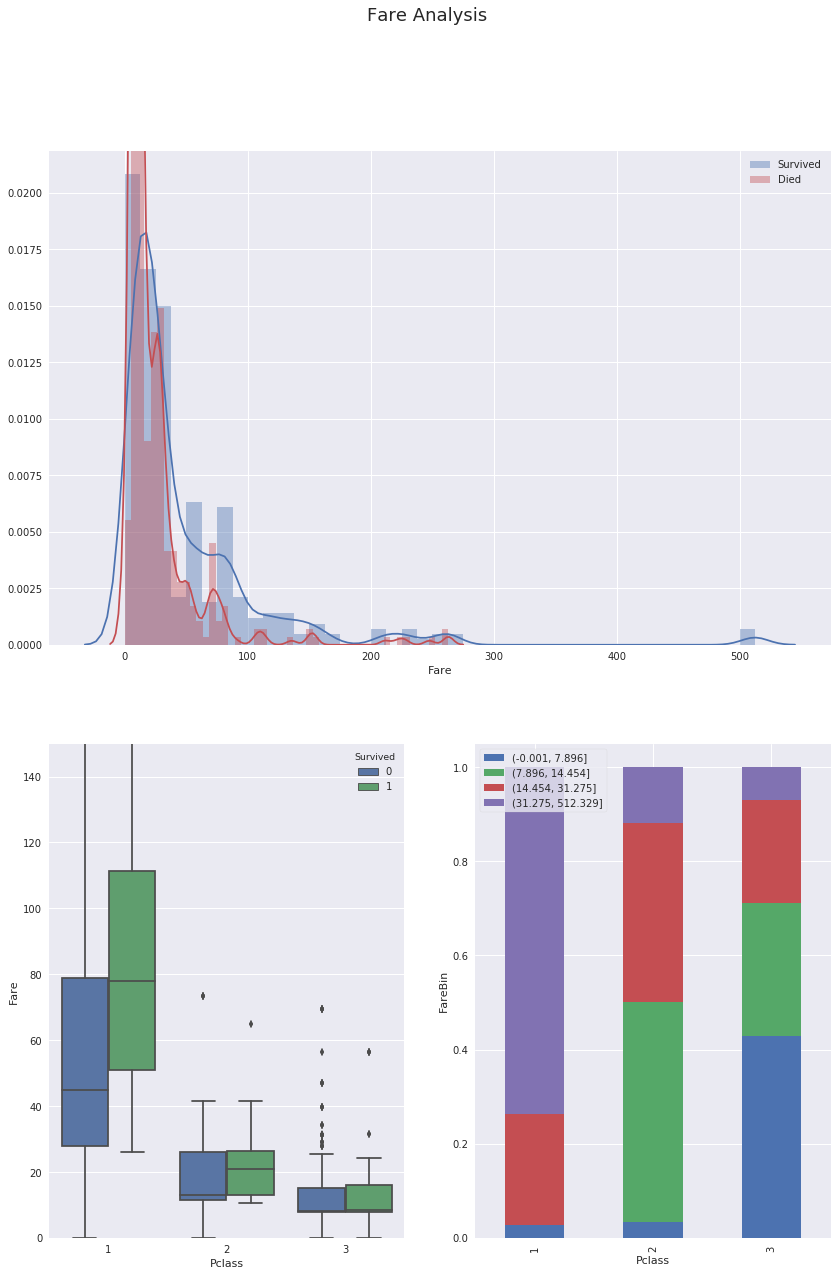

In [50]:
plt.figure(figsize=(14,20))
plt.subplot(211)
sns.distplot(df_train['Fare'][df_train.Survived == 1], color='b')
sns.distplot(df_train['Fare'][df_train.Survived == 0], color='r')
plt.legend(["Survived", "Died"])
plt.subplot(223)
sns.boxplot('Pclass', 'Fare', 'Survived', df_train, orient='v')
plt.ylim((0,150))
ax1 = plt.subplot(224)
tab = pd.crosstab(df_train['Pclass'], df_train['FareBin'])
tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax=ax1)
plt.xlabel('Pclass')
plt.ylabel('FareBin')
plt.legend(frameon=True)

plt.suptitle("Fare Analysis", fontsize=18)
plt.show()

In [51]:
# Cabins

# mask
cabin_M = df_train["Cabin"] == 'M'
cabin_Mn = df_train["Cabin"] != 'M'

plt.subplot(211)
sns.barplot("Cabin", "Survived", data=df_train)
plt.subplot(223)
plt.bar('Missing', df_train.Cabin[cabin_M].count())
plt.bar('Not Missing', df_train.Cabin[cabin_Mn].count())
plt.subplot(224)
df_cabin = df_train.copy()
df_cabin["Cabin_Missing"] = df_train["Cabin"].apply(lambda f: 1 if f == 'M' else 0)
sns.barplot("Cabin_Missing", "Survived", data=df_cabin)
plt.show()

ValueError: incompatible sizes: argument 'height' must be length 7 or scalar

From these plots I think analysing Missing vs Non-missing better than to consider each cabin letter.

In [ ]:
for df in data_cleaner:
    df['Cabin_Missing'] = df.Cabin == 'M'
dummy_train['Cabin_Missing'] = df_train.Cabin == 'M'
dummy_test['Cabin_Missing'] = df_test.Cabin == 'M'

# 4. Learning: Logistic Regression

I will create a test set to evaluate my model

In [ ]:
for e in dummy_train.columns:
    if e not in dummy_test.columns:
        print(e)
print('*'*10)
for e in dummy_test.columns:
    if e not in dummy_train.columns:
        print(e)

In [ ]:
dummy_test['Cabin_T'] = 0 #dirty fix

In [ ]:
dummy_test.columns

In [ ]:
# Features mask
# features = ["AgeBin_(0.0902, 16.136]", "AgeBin_(16.136, 32.102]", "AgeBin_(32.102, 48.068]",
#             "AgeBin_(48.068, 64.034]", "AgeBin_(64.034, 80.0]", "Cabin_M", "Sex_female",
#             "Parch", "SibSp", "FamilySize", "Embarked_Q", "Embarked_S", "Embarked_C", "Title_Rare",
#             "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "FareBin_(-0.001, 7.896]",
#             "FareBin_(7.896, 14.454]", "FareBin_(14.454, 31.275]", "FareBin_(31.275, 512.329]",
#             "Pclass_1", "Pclass_2", "Pclass_3"]

features = ['IsChild', 'IsOld', 'IsAlone', 'LargeFamily', 'Sex_female', "FareBin_(-0.001, 7.896]",
            "FareBin_(7.896, 14.454]", "FareBin_(14.454, 31.275]", "FareBin_(31.275, 512.329]",
            "Pclass_1", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S", "Embarked_C",
           "Title_Rare", 'Cabin_Missing']

In [ ]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(dummy_train[features].values, dummy_train[target].values, test_size=0.25, stratify=dummy_train[target].values)
X.shape, X_test.shape, y.shape, y_test.shape

In [ ]:
params = {
    'polynomialfeatures__degree': [1, 2],
    'classification__penalty': ['l1', 'l2'],
    'classification__C': [0.06, 0.1, 0.3, 0.6, 1, 3, 6]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures()),
    ('classification', LogisticRegression())
])
    
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=2)

In [ ]:
grid.fit(X , y.ravel())

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
grid.score(X_test, y_test)

In [ ]:
lg = grid.best_estimator_

# 5. Predicting

In [ ]:
lg.fit(dummy_train[features].values, dummy_train[target].values.ravel())

In [ ]:
pred = lg.predict(dummy_test[features].values)

In [ ]:
df_pred = pd.concat([df1_test["PassengerId"], pd.Series(pred, name="Survived")], axis=1)

In [ ]:
df_pred.head()

In [ ]:
df_pred.to_csv("out.csv", index=False)

# 6. Improvements

## 6.1 RFE

In [ ]:
X, X_test, y, y_test = train_test_split(dummy_train[features].values, dummy_train[target].values, test_size=0.25, stratify=dummy_train[target].values)
X.shape, X_test.shape, y.shape, y_test.shape

In [ ]:
rfe = RFECV(LogisticRegression())
X_new = rfe.fit_transform(X, y)

In [ ]:
X_new_test =rfe.transform(X_test)

## 6.2 Linear Regression for estimating Age

In [ ]:
# TODO

## 6.3 Non-linear classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

features = ["Age", "Cabin_M", "Sex_female", "Parch", "SibSp", "FamilySize", "Embarked_Q",
            "Embarked_S", "Embarked_C", "Title_Rare", "Title_Master", "Title_Miss", "Title_Mr",
            "Title_Mrs", "Fare", "Pclass_1", "Pclass_2", "Pclass_3"]

params = {
    'classification__n_estimators': [10, 30, 60, 100, 300, 600],
    'classification__max_depth': [2,4,6,8,10,None],
    'classification__criterion': ['gini', 'entropy']
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(RandomForestClassifier())),
    ('classification', RandomForestClassifier())
])
    
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=3)

In [ ]:
grid.fit(X, y.ravel())

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
pred = grid.best_estimator_

In [ ]:
pred.fit(dummy_train[features].values, dummy_train[target].values.ravel())

In [ ]:
prediction = pred.predict(dummy_test[features])

In [ ]:
df_pred = pd.concat([df1_test["PassengerId"], pd.Series(prediction, name="Survived")], axis=1)

In [ ]:
df_pred.head()

In [ ]:
#df_pred.to_csv("out1.csv", index=False)